# Preparing Data 4 the AE

### Import modules and Files

In [1]:
import pandas as pd
import numpy as np
import timeit, math, os, copy, yaml, ast
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.optimize import curve_fit

from drawing_utilities import *
import numpy as np
import copy
#%load_ext memory_profiler

In [23]:
# Rebinning 
rebin_val = 2 # (0 = no rebin, 1 = rectangular rebin, 2 = "Merge" bins in the low eta region).
if rebin_val == 1:
    from rebinning import XY_to_Polar, rebin_rect, rebin_whole
if rebin_val == 2:
    from rebinning import station_radii, draw_wheels, assign_colors, make_concentric_disks, make_disk, station3_boundaries, rebin, make_rebin_regions
    

In [3]:
out_label = "180924"
me = "hRHGlobalm2"
monitoring_elements = pd.read_parquet(me+'_'+out_label+'_s0.parquet')

In [4]:
#removing from dataset instances corresponding to zero inst luminosity
monitoring_elements = monitoring_elements[monitoring_elements["mean_lumi"] > 2]
monitoring_elements.reset_index(inplace=True)

In [5]:
#normalising to lumi/1000 to get entries * pb-1s-1 as unit
monitoring_elements["data_norm"] = monitoring_elements["data"]/(0.001*monitoring_elements["mean_lumi"])
monitoring_elements["entries_norm"] = monitoring_elements["entries"]/(0.001*monitoring_elements["mean_lumi"])

### Occupancy Plots

#### Occupancy vs Lumi

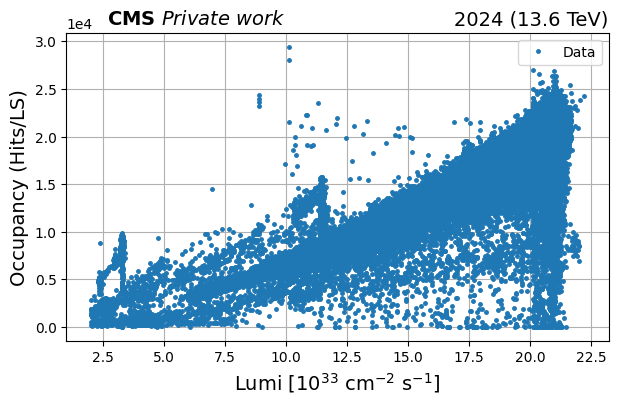

In [6]:
Show1Dimg(monitoring_elements['mean_lumi'], monitoring_elements['entries'])

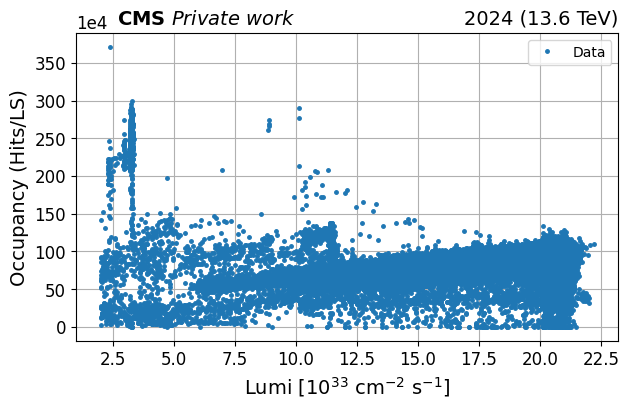

In [7]:
Show1Dimg(monitoring_elements['mean_lumi'], monitoring_elements['entries_norm'])

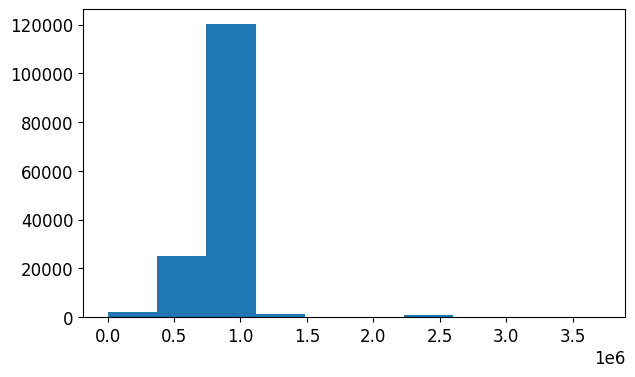

In [8]:
plt.figure(figsize=(7, 4))
plt.hist(monitoring_elements['entries_norm'])
plt.show()

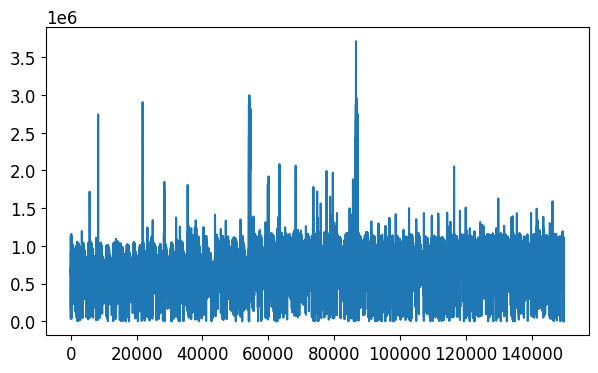

In [9]:
plt.figure(figsize=(7, 4))
plt.plot(monitoring_elements['entries_norm'])
plt.show()

In [10]:
monitoring_elements = monitoring_elements.sort_values(by=['run_number', 'ls_number'])
monitoring_elements.reset_index(inplace=True)

### Sum over LS

Mean lumi: 2.181817071533


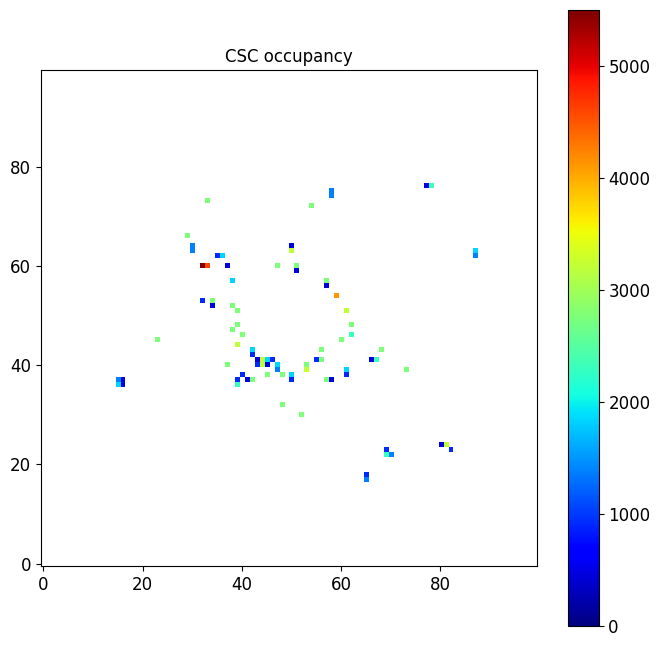

Mean lumi: 20.068316992187498


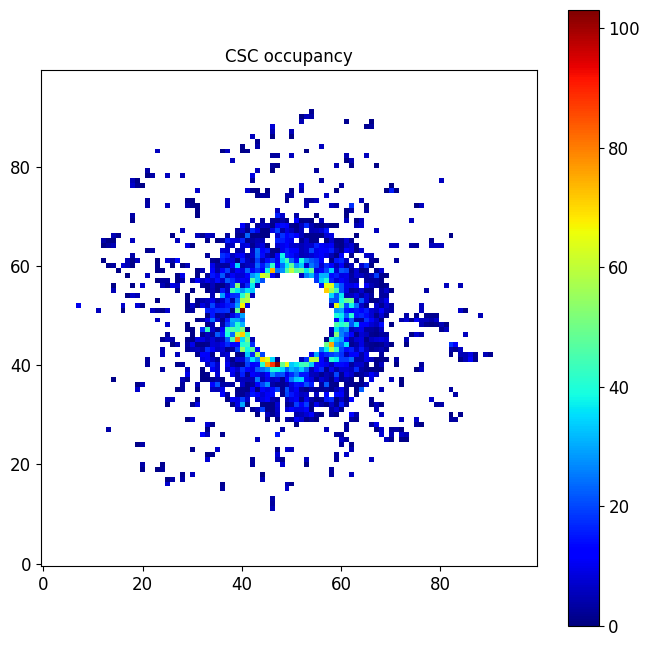

In [11]:
print("Mean lumi:", monitoring_elements["mean_lumi"][0])
img = Make_img(monitoring_elements['data_norm'][0], monitoring_elements['x_bin'][0], monitoring_elements['x_min'][0], monitoring_elements['x_max'][0], monitoring_elements['y_bin'][0], monitoring_elements['y_min'][0], monitoring_elements['y_max'][0])
Show2Dimg(img)
print("Mean lumi:", monitoring_elements["mean_lumi"][2000])
img = Make_img(monitoring_elements['data'][2000], monitoring_elements['x_bin'][0], monitoring_elements['x_min'][0], monitoring_elements['x_max'][0], monitoring_elements['y_bin'][0], monitoring_elements['y_min'][0], monitoring_elements['y_max'][0])
Show2Dimg(img)

In [12]:
def hadd_img(df, lumi_threshold):
    count = 0
    summed_img = []
    summed_lumi = []
    summed_entries = []
    summed_number = []
    run_min = []
    run_max = []
    lumi_min = []
    lumi_max = []
    dfs = []
    count = 0
    for it in range(len(df)):
        new_row = {'data_norm': df['data_norm'][it], 'lumi': df['mean_lumi'][it], 'entries_norm': df['entries_norm'][it]}
        if count == 0:
            run_min.append(df['run_number'][it])
            lumi_min.append(df['ls_number'][it])
        dfs.append(new_row)
        count +=1
        df_temp = pd.DataFrame(dfs)
        sumlumi = sum(df_temp['lumi'])
        if sumlumi >lumi_threshold: #to be divided by 1000 to get pb-1/s
            run_max.append(df['run_number'][it])
            lumi_max.append(df['ls_number'][it])
            sumdata = sum(df_temp['data_norm'])
            summed_img.append(Make_img(sumdata, df['x_bin'][0], df['x_min'][0], df['x_max'][0], df['y_bin'][0], df['y_min'][0], df['y_max'][0]))
            summed_lumi.append(sumlumi)
            summed_entries.append(sum(df_temp['entries_norm']))
            summed_number.append(count)
            count = 0
            dfs = []
            del sumdata
        del df_temp
        del sumlumi
        del new_row
    print("Total imgs: ",len(summed_img))
    return summed_img, summed_lumi, summed_entries, summed_number, run_min, run_max, lumi_min, lumi_max


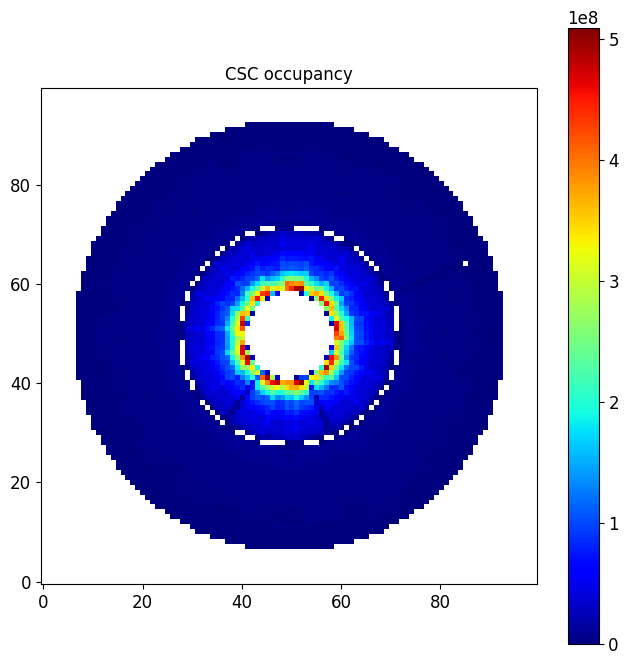

In [13]:
#have a look to the total (summed) distribution
sum_img = Make_img(sum(monitoring_elements['data_norm']), monitoring_elements['x_bin'][0], monitoring_elements['x_min'][0], monitoring_elements['x_max'][0], monitoring_elements['y_bin'][0], monitoring_elements['y_min'][0], monitoring_elements['y_max'][0])
Show2Dimg(sum_img)

In [14]:
#hadding consecutive ls to get a given total lumi
imgs, lumis, entry, num, run_min, run_max, lumi_min, lumi_max = hadd_img(monitoring_elements, 300) #corresponds to 0.3 pb-1/s

Total imgs:  8551


In [15]:
if len(run_min)>len(run_max):
    run_min.pop()
    lumi_min.pop()    

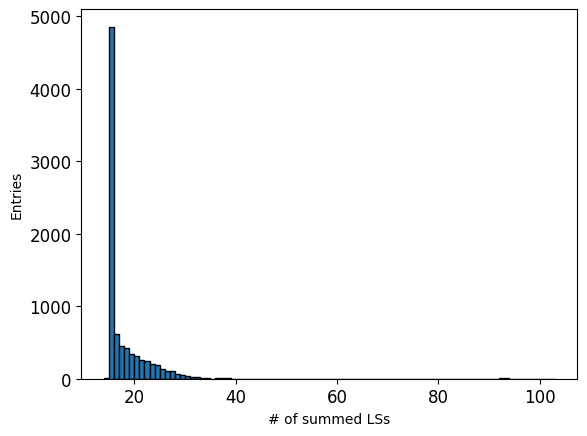

In [16]:
#this plot tells you how many consequent ls were summed up
plt.hist(num, bins=max(num)-min(num), edgecolor='black')
plt.xlabel('# of summed LSs')
plt.ylabel('Entries')
plt.show()

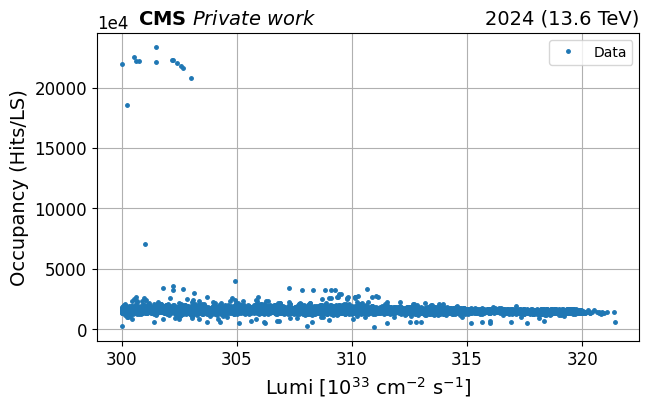

In [17]:
Show1Dimg(lumis, entry)

In [18]:
def entry_plot(entry):
    mean_entries_norm = np.mean(entry)
    std_entries_norm = np.std(entry)
    up = mean_entries_norm+1*std_entries_norm
    down = mean_entries_norm-1*std_entries_norm
    
    plt.figure(figsize=(7, 4))
    plt.plot(entry, label='entries_norm', alpha=0.7)
    
    plt.axhline(y=mean_entries_norm, color='r', linestyle='--', linewidth=2, label='Mean')
    
    plt.fill_between(
        range(len(entry)),
        down,  
        up,  
        color='red',
        alpha=0.5,  
        label='±1 STD'  
    )
    
    plt.fill_between(
        range(len(entry)),
        up,  
        up+std_entries_norm,  
        color='orange',
        alpha=0.5,  
        label='±2 STD'  
    )
    plt.fill_between(
        range(len(entry)),
        down-std_entries_norm,  
        down,
        color='orange',
        alpha=0.5,
    )
    
    plt.fill_between(
        range(len(entry)),
        up+std_entries_norm,  
        up+2*std_entries_norm,  
        color='yellow',
        alpha=0.5,  
        label='±3 STD'  
    )
    plt.fill_between(
        range(len(entry)),
        down-2*std_entries_norm,  
        down-std_entries_norm,
        color='yellow',
        alpha=0.5,
    )
    
    plt.legend()
    
    plt.show()

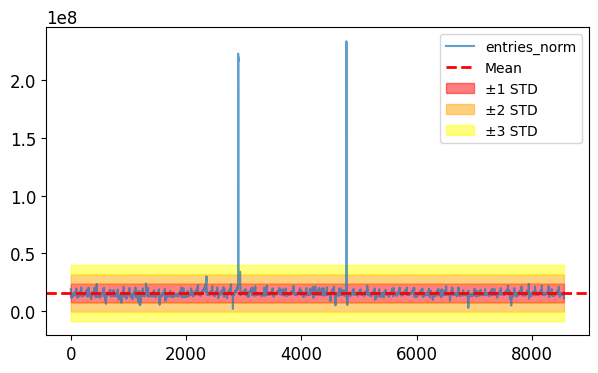

In [19]:
entry_plot(entry)

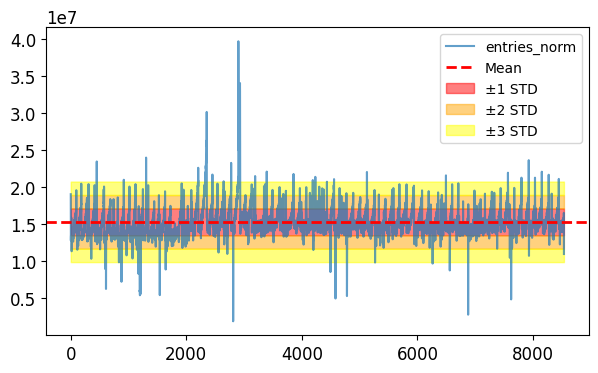

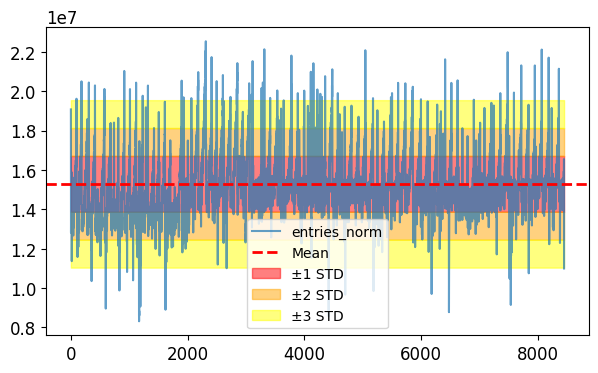

In [20]:
mean_entries_norm = np.mean(entry)
std_entries_norm = np.std(entry)
entry2 = [e for e in entry if abs(e - mean_entries_norm) < 4 * std_entries_norm] 
entry_plot(entry2)
mean_entries_norm = np.mean(entry2)
std_entries_norm = np.std(entry2)
bad_flag = [1 if abs(e - mean_entries_norm) < 4 * std_entries_norm else 0 for e in entry]
entry2 = [entry[e] for e in range(len(entry)) if bad_flag[e]==1] 
entry_plot(entry2)

In [21]:
mean_matrix = np.mean(imgs, axis=0)
binary_matrix = (mean_matrix != 0).astype(float);

In [30]:
if rebin_val == 0:
    np.savez(me+'_'+out_label+'_s1.npz', imgs=imgs, lumis=lumis, entry=entry, num=num, run_min=run_min, run_max=run_max, lumi_min=lumi_min, lumi_max=lumi_max, bad_flag=bad_flag)
elif rebin_val == 1:
    compressed_imgs = [rebin_whole(XY_to_Polar(img),11,4,1) for img in imgs]
    np.savez(me+'_'+out_label+'_s1.npz', imgs=compressed_imgs, no_rebin_imgs=imgs, lumis=lumis, entry=entry, num=num, run_min=run_min, run_max=run_max, lumi_min=lumi_min, lumi_max=lumi_max, bad_flag=bad_flag)
elif rebin_val == 2:
    inner_radius,outer_radius = station3_boundaries()
    regions = make_rebin_regions(sum_img,inner_radius,outer_radius,3,2)
    new_imgs = np.array([rebin(regions, img) for img in imgs])
    np.savez(me+'_'+out_label+'_s1.npz', imgs=new_imgs, no_rebin_imgs=imgs, lumis=lumis, entry=entry, num=num, run_min=run_min, run_max=run_max, lumi_min=lumi_min, lumi_max=lumi_max, bad_flag=bad_flag)

## Rebinning examples:

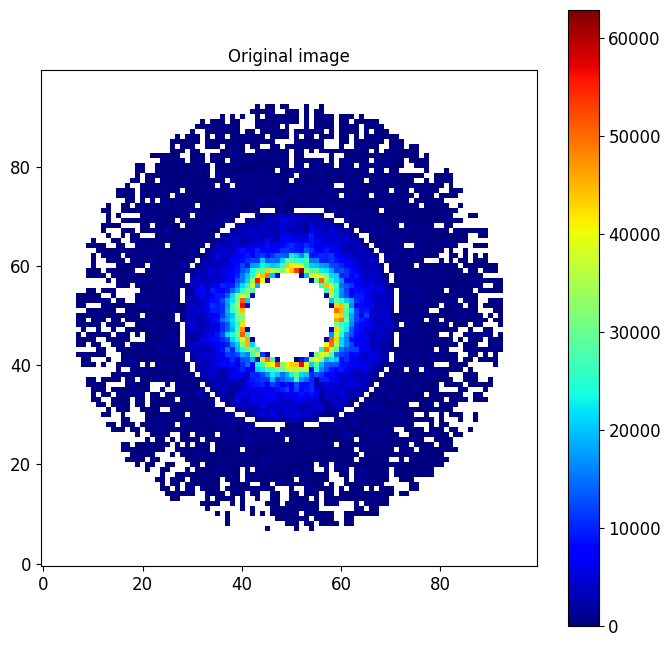

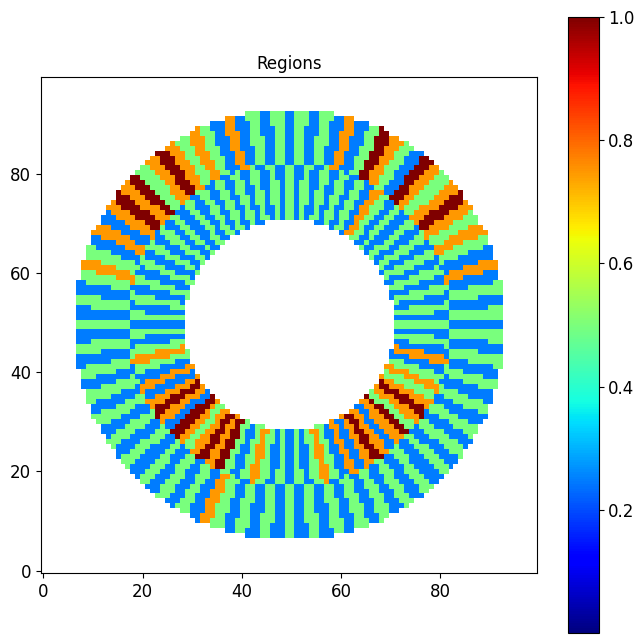

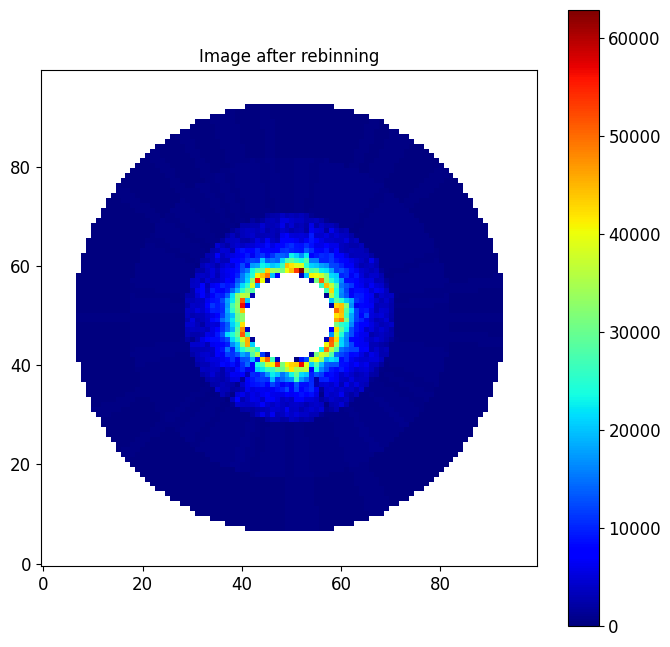

In [31]:
if rebin_val == 1:
    Show2Dimg(imgs[35], title = "Original image")
    Show2Dimg(compressed_imgs[35], title = "Rectangularized and compressed image")
elif rebin_val == 2:
    Show2Dimg(imgs[35], title = "Original image")
    Show2Dimg(assign_colors(regions), title = "Regions")
    Show2Dimg(new_imgs[35], title = "Image after rebinning")
